In [82]:
import tensorflow
from tensorflow import keras
import numpy as np
import os
from glob import glob
from glob import iglob
from PIL import Image

In [83]:
# Image Resizing Method
def resize_images(img_path):
	images=glob(img_path + "/*.png")  
 
	print(len(images), " images to be resized.")
 
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "PNG")
  
	print(len(images), " images resized.")

# Data Loading Method
def load_data(img_path, number_of_data=100):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=4
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in iglob(img_path+'/scissors/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    for file in iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1  

    for file in iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

In [84]:
# Resize the Data Images : Train
image_dir_path = "dataset/train/scissors"
resize_images(image_dir_path)
image_dir_path =  "dataset/train/rock"
resize_images(image_dir_path)
image_dir_path = "dataset/train/paper"
resize_images(image_dir_path)

# Resize the Data Images : Test
image_dir_path = "dataset/test/scissors"
resize_images(image_dir_path)
image_dir_path =  "dataset/test/rock"
resize_images(image_dir_path)
image_dir_path = "dataset/test/paper"
resize_images(image_dir_path)


840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
840  images to be resized.
840  images resized.
124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.
124  images to be resized.
124  images resized.


In [85]:
# Load the Dataset : Train
image_dir_path = "dataset/train"
x_train, y_train = load_data(image_dir_path, number_of_data=2520)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

# Load the Dataset : Test
image_dir_path = "dataset/test"
x_test, y_test = load_data(image_dir_path, number_of_data=372)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))


학습데이터(x_train)의 이미지 개수는 2520 입니다.
x_train shape: (2520, 28, 28, 4)
y_train shape: (2520,)
학습데이터(x_train)의 이미지 개수는 372 입니다.
x_test shape: (372, 28, 28, 4)
y_test shape: (372,)


In [86]:

# 하이퍼 파라미터
kernel_regularizer = keras.regularizers.L1(0.001)
# kernel_regularizer = None

# 모델 설계
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(28,28,4)))

model.add(keras.layers.Conv2D(16, (3,3), kernel_regularizer=kernel_regularizer))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(32, (3,3), kernel_regularizer=kernel_regularizer))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(64, (3,3), kernel_regularizer=kernel_regularizer))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='softmax'))

# 모델 개요
model.summary()

# 모델 컴파일
optimizer = 'adam'
loss = 'sparse_categorical_crossentropy',
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 26, 26, 8)         296       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
dropout_33 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
activation_33 (Activation)   (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 10, 10, 32)      

In [93]:
# 하이퍼 파라미터
epochs = 1000

# 콜백 지정
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
]

# 모델 학습
result = model.fit(x_train_norm, y_train, validation_split=0.3, epochs=epochs, callbacks=callbacks)

# 모델 평가
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

Epoch 1/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0608 - accuracy: 0.9989 - val_loss: 0.0621 - val_accuracy: 1.0000
Epoch 2/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0668 - accuracy: 0.9983 - val_loss: 0.4025 - val_accuracy: 0.9272
Epoch 3/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0518 - accuracy: 0.9994 - val_loss: 0.0407 - val_accuracy: 1.0000
Epoch 4/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0397 - accuracy: 0.9989 - val_loss: 0.5156 - val_accuracy: 0.8545
Epoch 5/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.8170 - val_accuracy: 0.7738
Epoch 6/1000
56/56 [==============================] - 0s 5ms/step - loss: 0.0290 - accuracy: 0.9989 - val_loss: 0.7655 - val_accuracy: 0.7989
Epoch 7/1000
56/56 [==============================] - 0s 6ms/step - loss: 0.0432 - accuracy: 0.9994 - val_loss: 0.1565 - val_accuracy: 0.9524
Epoch 

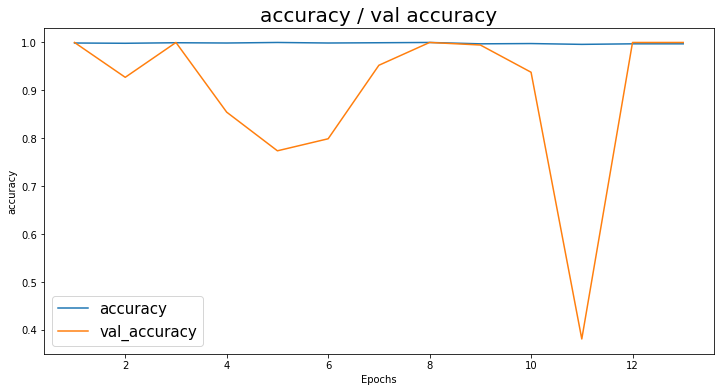

In [102]:
# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(result.history['accuracy'])+1), result.history['accuracy'])
plt.plot(np.arange(1, len(result.history['val_accuracy'])+1), result.history['val_accuracy'])
plt.title('accuracy / val accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], fontsize=15)
plt.show()
